# Early Warning Models for Financial Crisis using Machine Learning Techniques

### Yelebe Desta and Seth Tenberg

In [1022]:
# I found out why neural network was so good. its because i included the year and country as variables. 
# So i fixed that, and now the neural network model is just as good as logistic, a little worse than lasso. 
# I also included other variables into the neural network
# shap values are having difficulty but its in a 'good enough' state

# fix grad boost


# Lit Review

In [ ]:
!pip 

# Cleaning the Data

In [2432]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

set_seed(455)


In [2433]:
data = pd.read_excel("C:/Users/sjten/Downloads/JSTdatasetR6 (1).xlsx")

# Exploring the Data

In [2434]:
data['year']

0       1870
1       1871
2       1872
3       1873
4       1874
        ... 
2713    2016
2714    2017
2715    2018
2716    2019
2717    2020
Name: year, Length: 2718, dtype: int64

In [2435]:
data.describe()

,year,ifs,pop,rgdpmad,rgdpbarro,rconsbarro,gdp,iy,cpi,ca,...,eq_capgain,eq_dp,eq_capgain_interp,eq_tr_interp,eq_dp_interp,bond_rate,eq_div_rtn,capital_tr,risky_tr,safe_tr
count,2718.00000,2718.000000,2667.000000,2666.000000,2664.000000,2561.000000,2.641000e+03,2425.000000,2.666000e+03,2.489000e+03,...,2.170000e+03,2169.000000,7.0,7.0,6.0,2381.000000,2163.000000,1830.000000,1854.000000,2247.000000
mean,1945.00000,148.333333,31439.397574,9155.064763,39.793748,42.133609,2.454826e+06,0.188838,4.191118e+01,-4.572271e+04,...,1.167935e+06,0.040949,1.0,1.0,1.0,0.054346,0.042763,0.099308,0.111523,0.051634
std,43.59701,24.165940,45898.993728,7976.190143,33.884462,32.274402,1.615548e+07,0.064621,5.689962e+01,7.670287e+05,...,5.440622e+07,0.017111,0.0,0.0,0.0,0.031442,0.017694,0.090360,0.110373,0.048357
min,1870.00000,111.000000,1675.000000,737.375497,3.263085,4.074400,1.250757e-11,0.017287,1.150362e-11,-1.687900e+07,...,-8.842261e-01,0.000000,1.0,1.0,1.0,-0.035316,0.000000,-0.232140,-0.238515,-0.152371
25%,1907.00000,132.000000,4866.650000,2873.047663,12.694448,15.650000,5.428200e+01,0.140980,2.526395e+00,-6.345947e+01,...,-5.496224e-02,0.030100,1.0,1.0,1.0,0.036000,0.032112,0.047950,0.051188,0.024857
50%,1945.00000,143.000000,10113.530000,5477.011227,23.056114,27.846700,1.810926e+03,0.194356,1.050679e+01,-3.300000e-02,...,4.175594e-02,0.040665,1.0,1.0,1.0,0.046100,0.042530,0.090982,0.102568,0.043005
75%,1983.00000,172.000000,45077.000000,14619.435708,65.770534,68.720000,5.038345e+04,0.230288,7.617557e+01,1.788000e+01,...,1.568719e-01,0.051569,1.0,1.0,1.0,0.063500,0.053196,0.137372,0.159925,0.067896
max,2020.00000,193.000000,329239.715278,45887.569802,147.282620,120.431162,2.070466e+08,0.546975,2.268252e+02,5.885998e+06,...,2.534419e+09,0.127113,1.0,1.0,1.0,0.237154,0.138189,1.144161,1.281639,0.408514


We want to make a early warning indicator model, thus our dependent variable of interest is not when the crisis occurs, but a year or two *before* the crisis occurs. The dataset being used encodes the year that a crisis occurs; we can do a quick fix to create our binary dependent variable.

In [2436]:
data['indicator'] = ((data['crisisJST'].shift(-1) == 1) | (data['crisisJST'].shift(-2) == 1)).astype(int)


Now we will remove the year of the crisis along with the following four years to remove post crisis bias, which has been shown to affect analysis in previous research.

In [2437]:
crisis_rows = data[data['crisisJST'] == 1].index.tolist()
crisis_rows_incremented1 = [row + 1 for row in crisis_rows]
crisis_rows_incremented2 = [row + 2 for row in crisis_rows]
crisis_rows_incremented3 = [row + 3 for row in crisis_rows]
crisis_rows_incremented4 = [row + 4 for row in crisis_rows]

crisis_rows_df = pd.DataFrame(
    {'crisis_rows': crisis_rows,
     'crisis_rows_incremented1': crisis_rows_incremented1,
     'crisis_rows_incremented2': crisis_rows_incremented2,
     'crisis_rows_incremented3': crisis_rows_incremented3,
     'crisis_rows_incremented4': crisis_rows_incremented4})

rows_to_remove = pd.concat([crisis_rows_df[col] for col in crisis_rows_df.columns])

# Sort the values in the combined column
rows_to_remove = rows_to_remove.sort_values()
# remove the rows from the data to account for crisis bias
data = data.drop(data.index[rows_to_remove])
# we have removed 435 from the dataset

Now we wil account for extraordinary events in history, and remove the years during which World War 1, the Great Depression, and World War 2. Then we will also create two new variables for our analysis. We create a measure of global credit creation, and a measure for the global slope of the yield curve.

In [2438]:
# we will create a variable the measures the slope of the yield curve, subtracting short term interest rates from long term interest rates
data['slope'] = (data['ltrate'] - data['stir'])
# removing years for WW1, WW2, and Great Depression
data_filtered = data[(data['year'] < 1914) | (data['year'] > 1918)]
data = data_filtered[(data_filtered['year'] < 1933) | (data_filtered['year'] > 1945)]
data['year']
# now we will create our global slope and credit variables
grouped = data.groupby('year')
data = grouped.apply(lambda x: x.assign(
    global_slope=x.loc[x['country'] != x['country'].iloc[0], 'slope'].mean()
))

# Ungroup
data= data.reset_index(drop=True)

#making Debt Servicing Ratio Variable
data['DSR'] = (data['tloans'] - (data['ltrate']/data['gdp']))

To ensure stationarity of the time series data, we will augment most of our variables. CPI, Real Consumption per Capita, Housing prices, Money Supply, Credit Supply, Investment, and current account are all converted into growth rates ratios of GDP. We also change Stock prices, Debt/GDP ratio, and Debt Servicing Ratio are all changed into one year rates of change. 

In [2439]:
data_rate = data.groupby('country').apply(lambda group: 
    group.assign(
        cpi_rate = (group['cpi'] - group['cpi'].shift(1)) / group['cpi'].shift(1),
        rconsumption_rate = (group['rconsbarro'] - group['rconsbarro'].shift(1)) / group['rconsbarro'].shift(1),
        housing_rate = (group['hpnom'] - group['hpnom'].shift(1)) / group['hpnom'].shift(1),
        money_rate = (group['money'] - group['money'].shift(1)) / group['money'].shift(1),
        DSR_rate = (group['DSR'] - group['DSR'].shift(1)/ group['DSR'].shift(1)),
        credit_rate = (group['tloans'] / group['gdp'] - group['tloans'].shift(1) / group['gdp'].shift(1)),
        ca_rate = (group['ca'] / group['gdp'] - group['ca'].shift(1) / group['gdp'].shift(1)),
        investment_rate = (group['iy'] - group['iy'].shift(1)),
        stock_rate =  ((group['capital_tr'] - group['capital_tr'].shift(1))/group['capital_tr'].shift(1)),
        debtgdp_rate = (group['debtgdp'] - group['debtgdp'].shift(1)),
        lev_rate = (group['lev'] - group['lev'].shift(1)),
        noncore_rate = (group['noncore'] - group['noncore'].shift(1))


    )
).reset_index(drop=True)

grouped = data_rate.groupby('year')
data_rate = grouped.apply(lambda x: x.assign(
    global_credit_rate=x.loc[x['country'] != x['country'].iloc[0], 'credit_rate'].mean()
))

# Ungroup
data_rate= data_rate.reset_index(drop=True)


In [2440]:
columns_to_keep = ['cpi_rate', 'rconsumption_rate', 'housing_rate', 'money_rate', 'DSR_rate', 'credit_rate', 
                   'global_credit_rate', 'slope', 'global_slope','ca_rate',  'investment_rate',  'debtgdp_rate', 'noncore_rate', 'lev_rate', 'stock_rate', 'indicator']
data_subset = data_rate[columns_to_keep]

missing_rows = data_subset[data_subset.isnull().any(axis=1)]

# Print the number of rows with missing values
print("Number of rows with missing values:", len(missing_rows))

Number of rows with missing values: 951


In [2441]:
subset_usa = data[data['country'] == 'USA'][['year', 'noncore']]
print(subset_usa)

      year    noncore
15    1870  35.743996
30    1871  35.539246
45    1872  37.567600
123   1878  18.651087
137   1879  17.214575
...    ...        ...
1934  2016  15.484300
1952  2017  15.200243
1970  2018  14.785629
1988  2019  14.108976
2006  2020  10.972219

[105 rows x 2 columns]


In [2442]:
# dropping all the rows with na's 
data_subset = data_subset.dropna()

In [2443]:
# standardizing the data
X = data_subset.drop(columns=['indicator'])
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
X_standardized = scaler.fit_transform(X)

# Convert the standardized array back to a DataFrame with column names
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)
X_standardized.head()
y = data_subset['indicator']

In [2444]:
X_standardized = X_standardized.rename(columns={'cpi_rate' : 'CPI Rate', 'rconsumption_rate' : 'Consumption Rate', 'housing_rate' : 'Housing Rate', 'money_rate' : 'Money Rate', 'DSR_rate' : 'DSR Rate',
                      'credit_rate' : 'Credit Rate', 'ca_rate' : 'CA Rate', 'investment_rate' : 'Investment Rate', 'stock_rate' : 'Stock Rate', 'debtgdp_rate' : 'Debt/GDP Rate',
                      'slope' : 'Slope', 'global_slope': 'Global Slope', 'global_credit_rate' : 'Global Credit Rate','lev_rate' : 'Leverage', 'noncore_rate' : 'Noncore'})
X_standardized.head()

,CPI Rate,Consumption Rate,Housing Rate,Money Rate,DSR Rate,Credit Rate,Global Credit Rate,Slope,Global Slope,CA Rate,Investment Rate,Debt/GDP Rate,Noncore,Leverage,Stock Rate
0,-0.692399,1.863803,-1.275025,0.232034,-9.774171,0.372076,1.004389,-0.597122,1.450977,0.455652,-3.187647,0.642133,1.805039,-9.998045,-0.200192
1,-0.627131,-1.129922,-0.489277,-0.331442,-9.580488,0.047627,0.004045,-0.070608,0.644872,-0.214573,-1.711090,0.642133,-0.042318,-0.669793,0.056269
2,-0.017208,-1.905575,-0.962707,-0.392559,-9.114716,0.105955,-0.270948,-0.073565,0.330450,-0.123752,0.357629,0.354910,-0.167026,0.015099,-0.055297
3,-0.549623,-0.076285,0.484746,-0.074498,-8.731604,0.135452,-0.037695,-0.562146,-0.954545,0.135967,0.761965,0.067688,0.031964,0.231328,0.002696
4,-0.327021,-0.849147,-0.717554,-0.378533,-8.480827,-0.076233,0.601057,-0.428367,-1.046299,0.198573,-0.250115,0.211299,-0.216842,-0.118058,-0.059341


Now the data is standardized and the variable names are clear for future use later.

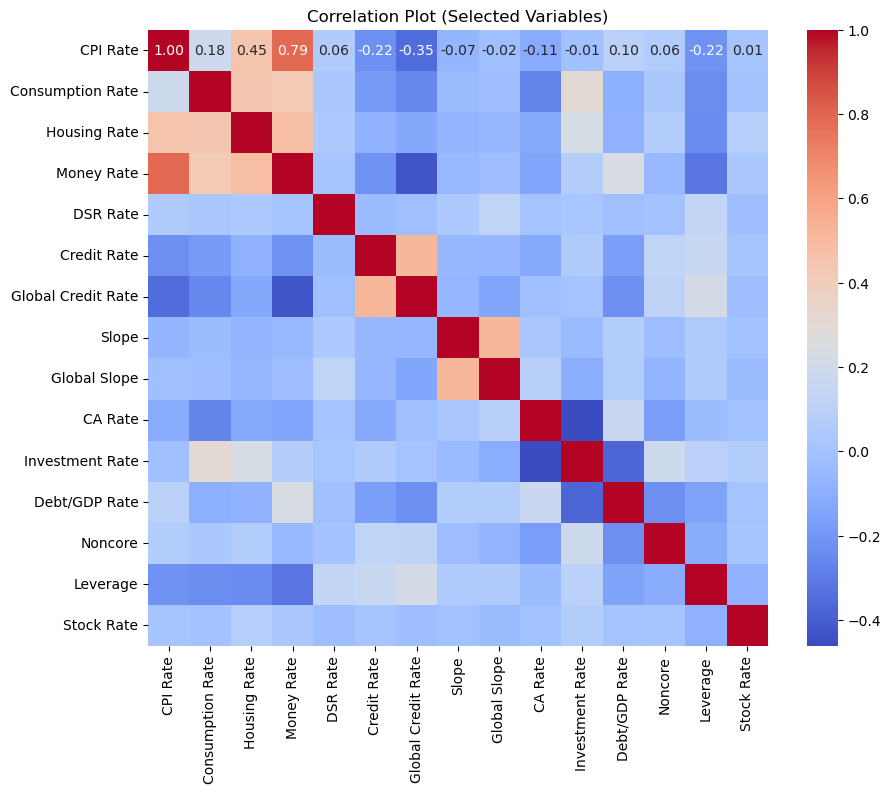

In [2445]:


# Calculate correlation matrix
correlation_matrix = X_standardized.corr()

# Create Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot (Selected Variables)')
plt.show()

While most variables are uncorrelated with one another, a few variables do have moderately strong relationships with our other explanatory variables. The CPI rate and the money supply growth rate have a very strong correlation (0.79). Noticably, the global and domestic slope variables have a correlation around 0.5. Our global and domestic variables appear to measure different things and are not highly correlated alternatives.

# Basic Logistic Model

To begin the analysis, we will construct a logistic model with all the variables included. This will serve as a baseline to reference for model performance. For analyze out-of-sample predictive performance, we will use a k-fold-crossfold validation method. Given the limited number of financial crises, splitting the data into a training and testing set would reduce predictive capabilities of the models. Previous research has shown that the two methods will perform comparably. We will use multiple methods to compare model performance. These methods include examining the *Receiver Operating Characteristic* space, Recall rate, and Shapley Values. These methods will be discussed later on.


We will now create the models that will be used for predicting financial crises. We will investigate the variables of importance and see if there are any variables that are consistantly important across all the models. Then the models will be tested for predictive performance.

In [2446]:
X_standardized['intercept']=1.0
#y #1057
#X_standardized #1057
y = list(y)
logit = sm.Logit(y, X_standardized)
logit_fit=logit.fit()


logit_fit.summary()
coeff = logit_fit.params

Optimization terminated successfully.
         Current function value: 0.207378
         Iterations 9


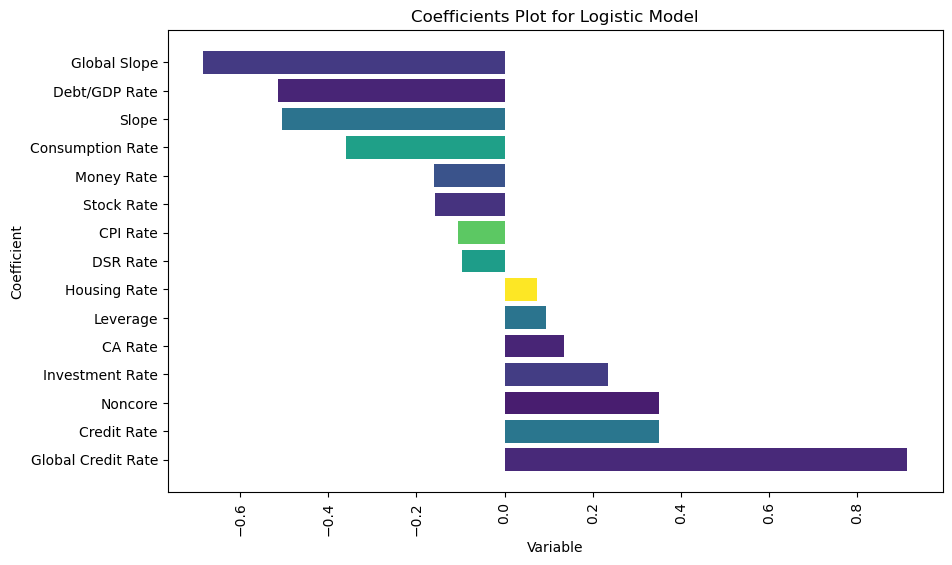

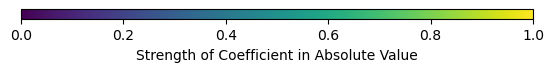

In [2447]:
coefficients = logit_fit.params
coefficients = coefficients.drop(['intercept'])
coef_names = coefficients.index

sorted_coefficients = sorted(zip(coefficients, coef_names), reverse=True)
sorted_coefficients, sorted_coef_names = zip(*sorted_coefficients)

cmap = plt.cm.viridis

plt.figure(figsize=(10, 6))
plt.barh(sorted_coef_names, sorted_coefficients, color=cmap(abs(coefficients) / max(abs(coefficients))))

plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Coefficients Plot for Logistic Model')
plt.xticks(rotation=90)
plt.show()

# Create a separate axis for the color bar at the bottom
cbar_ax = plt.axes([.1, 0.01, 0.8, 0.02])  # Adjust the position and size of the color bar axis
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cbar_ax, orientation='horizontal')
cbar.set_label('Strength of Coefficient in Absolute Value')

This chart illustrates the most important feautures in our logistic model. As seen above, the most important features are The global and domestic credit growth rates, the global and domestic yield curve slopes, noncore funding, and Debt/GDP ratio.

# Lasso Model

We will now implement penalized logistic models. First we create a Lasso logistic model and tune the model using cross-validation to find a good value for the penalty term. Then the coefficients are plotted from the model using the *good* penalty term.

In [2448]:
from sklearn.model_selection import cross_val_score

alpha_values = [0.0001, 0.001,0.005, 0.01, 0.1, 0.5, 1]
best_alpha = None
best_mse = float('inf')

cv_scores = {}

# Perform manual grid search with cross-validation
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X_standardized, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores[alpha] = np.mean(scores)

# Find the alpha with the best mean cross-validation score
best_alpha = min(cv_scores, key=cv_scores.get)
best_mse = -cv_scores[best_alpha]

print("Best Alpha:", best_alpha)
print("Best Cross-Validation MSE:", best_mse)

Best Alpha: 0.0001
Best Cross-Validation MSE: 0.07215348889817944


In [2449]:
from sklearn.linear_model import LinearRegression, Lasso
# model evaluation
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV


lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_standardized, y)


coeff_lasso = lasso_best.coef_
columns = ['Lasso_Coefficient', 'Feature']
new_df = pd.DataFrame(X_standardized.columns,coeff_lasso)





data = {'coeff_lasso': coeff_lasso, 'column_names': X_standardized.columns}

# Create DataFrame
df = pd.DataFrame(data)

df = df.drop(df.index[-1])

df = df.sort_values(by = 'coeff_lasso', ascending = False)



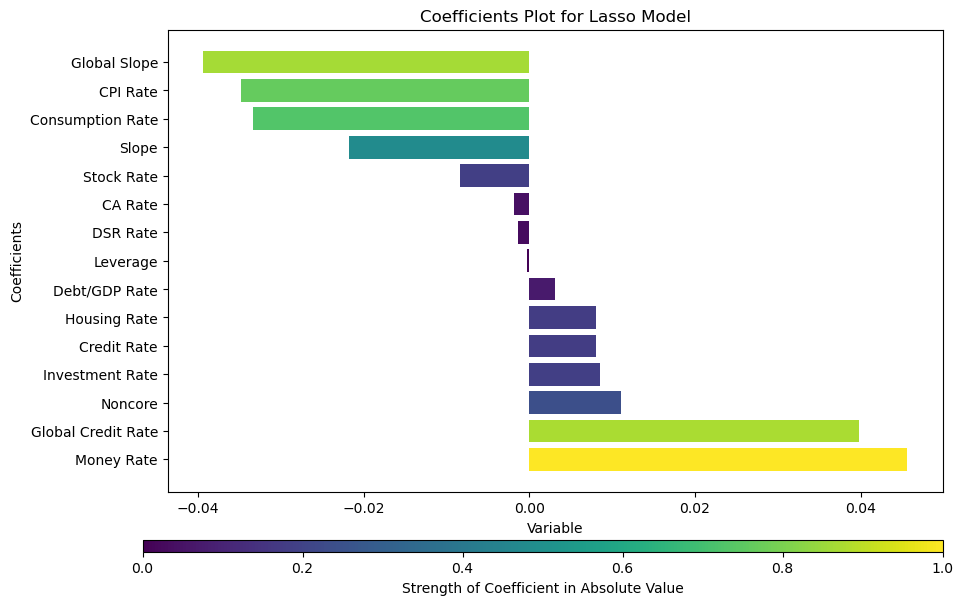

In [2450]:
column_names = df['column_names']
coeff_lasso = df['coeff_lasso']

# Define colormap 'viridis'
cmap = plt.cm.viridis

plt.figure(figsize=(10, 6))
bars = plt.barh(column_names, coeff_lasso, color=cmap(abs(coeff_lasso) / max(abs(coeff_lasso))))
plt.xlabel('Variable')
plt.ylabel('Coefficients')
plt.title('Coefficients Plot for Lasso Model')

# Create a separate axis for the color bar at the bottom
cbar_ax = plt.axes([0.1, 0.01, 0.8, 0.02])  # Adjust the position and size of the color bar axis
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cbar_ax, orientation='horizontal')
cbar.set_label('Strength of Coefficient in Absolute Value')

plt.show()

Positive values of the money supply growth rate, the global credit growth rate, and the noncore funding rate are all important for predicting financial crisis for the Lasso model. Likewise, negative values for the global slope of the yield curve, the cpi rate, and the consumption rate (GDP) are important for predicting financial crisis.

# Elastic Net Model

The Elastic Net model combines the techniques of Lasso and Ridge models. We follow the same procedure from above, and also tune the hyperparameter l1 ratio, which controls how similiar the model is to Ridge versus Lasso. The coefficients from the model are then plotted

In [2451]:
l1_ratio_values = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha_values = [  0.0001, 0.001,0.005, 0.01, 0.1, 0.5, 1]

cv_scores = {}

# Perform manual grid search with cross-validation
for alpha in alpha_values:
    for l1_ratio in l1_ratio_values:
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        scores = cross_val_score(elastic_net, X_standardized, y, cv=5, scoring='neg_mean_squared_error')
        cv_scores[(alpha, l1_ratio)] = np.mean(scores)

# Find the alpha and l1_ratio with the best mean cross-validation score
best_hyperparams = min(cv_scores, key=cv_scores.get)
best_alpha1, best_l1_ratio = best_hyperparams
best_mse = -cv_scores[best_hyperparams]

print("Best Alpha:", best_alpha1)
print("Best l1_ratio:", best_l1_ratio)
print("Best Cross-Validation MSE:", best_mse)

Best Alpha: 0.0001
Best l1_ratio: 0.1
Best Cross-Validation MSE: 0.08070185705872505


In [2452]:
elastic_net = ElasticNet()


elastic_net_best = ElasticNet(alpha = best_alpha, l1_ratio = best_l1_ratio)
elastic_net_best.fit(X_standardized, y)


coeff_elastic_net = elastic_net_best.coef_
columns = ['Elastic_Net_Coefficient', 'Feature']
new_df = pd.DataFrame(X_standardized.columns,coeff_elastic_net)


data = {'coeff_elastic_net': coeff_elastic_net, 'column_names': X_standardized.columns}

# Create DataFrame
df = pd.DataFrame(data)

df = df.drop(df.index[-1])

df = df.sort_values(by = 'coeff_elastic_net', ascending = False)



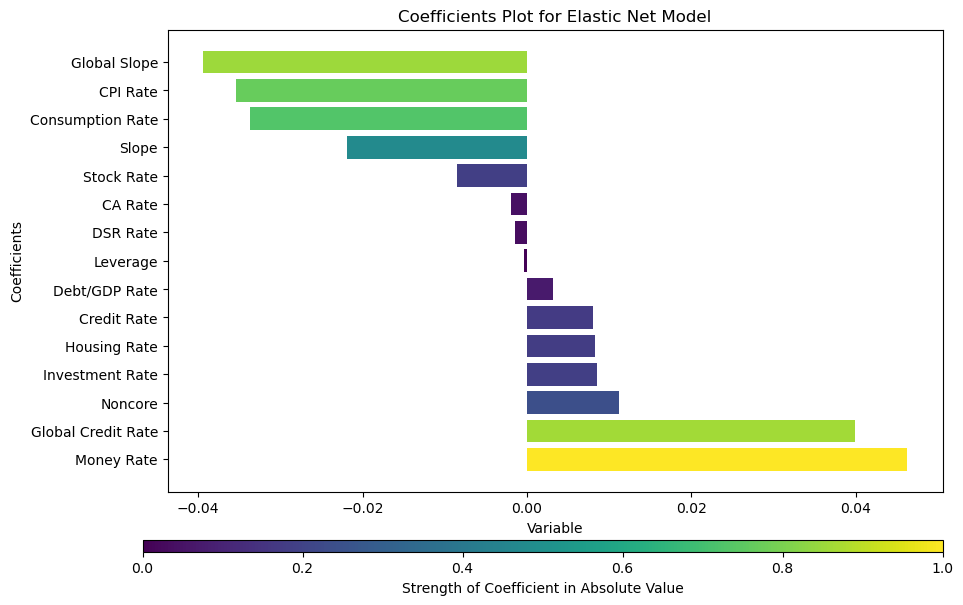

In [2453]:
column_names = df['column_names']
coeff_elastic_net = df['coeff_elastic_net']

# Define colormap 'viridis'
cmap = plt.cm.viridis

plt.figure(figsize=(10, 6))
bars = plt.barh(column_names, coeff_elastic_net, color=cmap(abs(coeff_elastic_net) / max(abs(coeff_elastic_net))))
plt.xlabel('Variable')
plt.ylabel('Coefficients')
plt.title('Coefficients Plot for Elastic Net Model')

# Create a separate axis for the color bar at the bottom
cbar_ax = plt.axes([0.1, 0.01, 0.8, 0.02])  # Adjust the position and size of the color bar axis
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cbar_ax, orientation='horizontal')
cbar.set_label('Strength of Coefficient in Absolute Value')

plt.show()

Once again we see negative values of global and domestic slope along with consumption and cpi are important for predicting crisis. Similarly, positive values of global an domestic credit growth, along with the money supply growth rate and noncore funding are important for the Elastic Net model

# Random Forest

Next we will fit a Random Forest model to the data. We will tune some of the hyperparameters to achieve a good fit, and view the variables by importance.

In [2454]:

forest = RandomForestRegressor()


param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': [3, 4, 5]
}
grid_search = GridSearchCV(estimator = forest, param_grid=param_grid, cv=5)
grid_search.fit(X_standardized, y)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_features = grid_search.best_params_['max_features']

forest_best = RandomForestClassifier(n_estimators = best_n_estimators, max_features = best_max_features)
forest_best.fit(X_standardized, y)

RandomForestClassifier(max_features=3, n_estimators=250)

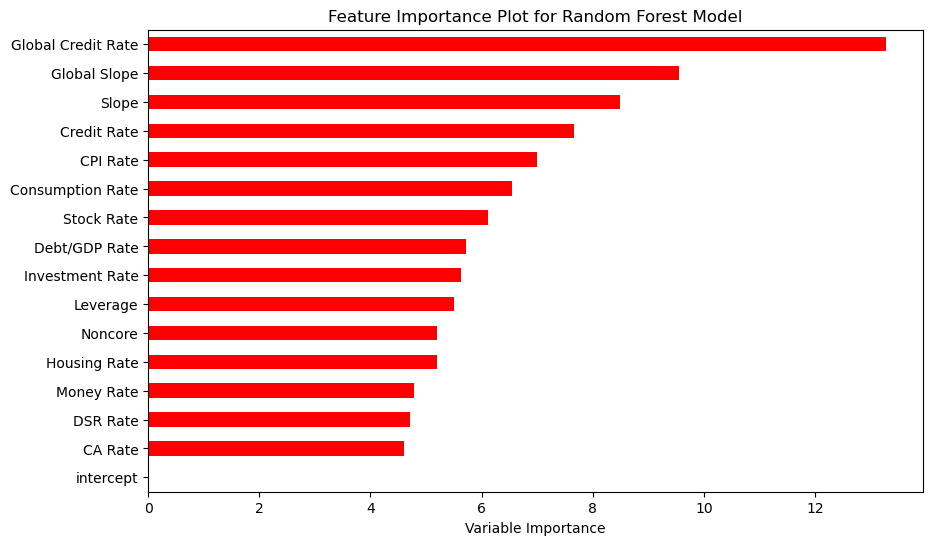

In [2455]:
Importance = pd.DataFrame({'Importance':forest_best.feature_importances_*100}, index=X_standardized.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', figsize = (10,6))
plt.xlabel('Variable Importance')
plt.title('Feature Importance Plot for Random Forest Model')
plt.gca().legend_ = None

The most important features for the Random Forest model include the global and domestic variables of yield curve slope and credit growth. The CPI and consumption rate are also important. 

# Gradient Boosted Forests

We will now add Gradient Boosting to the Random Forest model. Once again we will tune some of the hyperparameters and analyze the variables by importance. 

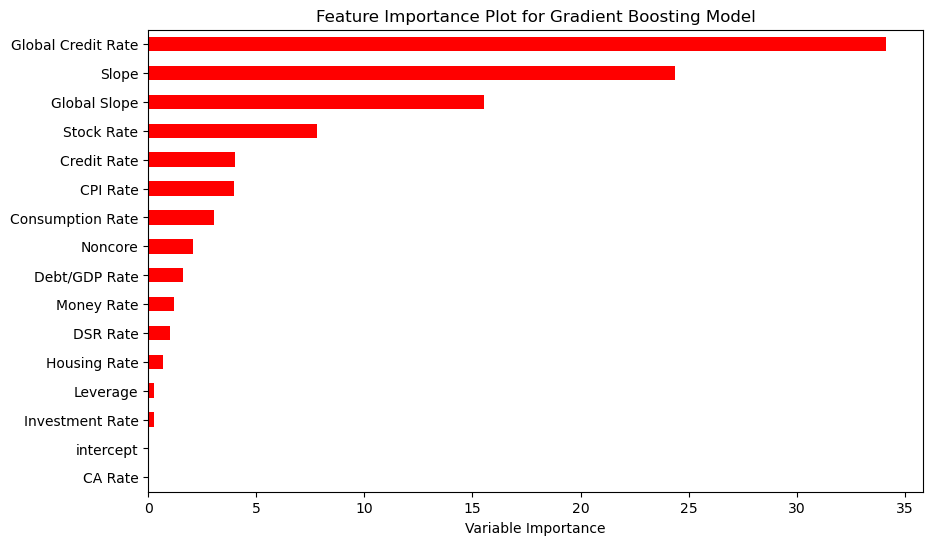

In [2456]:
# may take a while to run

gbm = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5)
grid_search.fit(X_standardized, y)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_learning_rate = grid_search.best_params_['learning_rate']

gbm_best = GradientBoostingClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=best_learning_rate)
gbm_best.fit(X_standardized, y)

importance = pd.DataFrame({'Importance': gbm_best.feature_importances_ * 100}, index=X_standardized.columns)
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', figsize=(10, 6))
plt.xlabel('Variable Importance')
plt.title('Feature Importance Plot for Gradient Boosting Model')
plt.gca().legend_ = None
plt.show()

The most important variables are the global and domestic slope and credit growth variables, along with the stock rate and cpi rate.

# Neural Networks

We will now fit and tune a neural network to the data. Previous research has shown that Long Short Term Memory models are able particularly effective for time series data. Thus we will use an LSTM model to predict financial crisis. We believe that macroeconomic dynamics that cause or predict crisis may be nonlinear and time dependent, as this is what previous research has suggested. Thus, we believe that the LSTM Model should provide a good forecast for financial crisis. 

In [2475]:
sorted_data_rate = data_rate.sort_values(by=['country', 'year'])
columns_to_keep = ['country', 'year' , 'credit_rate', 'lev_rate' ,'housing_rate', 'global_slope', 'slope', 'rconsumption_rate', 'stock_rate', 'global_credit_rate', 'indicator']
data_neural = sorted_data_rate[columns_to_keep]

missing_rows = data_neural[data_neural.isnull().any(axis=1)]

# dropping all the rows with na's 
data_neural = data_neural.dropna()

# standardizing the data
columns_to_standardize =  ['credit_rate',  'housing_rate', 'global_slope', 'slope', 'stock_rate','rconsumption_rate', 'lev_rate', 'global_credit_rate']
scaler = StandardScaler()
data_neural[columns_to_standardize] = scaler.fit_transform(data_neural[columns_to_standardize])



In [2476]:
train_data=data_neural.iloc[:int(len(data_neural)*0.7)] 
test_data=data_neural.iloc[int(len(data_neural)*0.7):]

Getting the panel data ready for the LSTM model proved challenging, but the steps are outlined below. The data is first split into a 70/30 training testing set. 

In [2477]:
def train_test_split(data):
    size=int(len(data)*0.7)
    # for train data will be collected from each country's data which index is from 0-size (70%)
    x_train =data.drop(columns=['indicator']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (30%)
    x_test = data.drop(columns=['indicator']).iloc[size:]
    y_train=data['indicator'].iloc[0:size] 
    y_test=data['indicator'].iloc[size:] 
    return x_train, x_test,y_train,y_test
# unique countries
country=list(set(data_neural.country))
# loop each country_Region and split the data into train and test data
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    df = data_neural[data_neural['country'] == country[i]]
    # applied the function I created above
    x_train, x_test,y_train,y_test=train_test_split(df)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)
# concatenate each train data n X_train list and Y_train list respectively
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

The data is then converted into a form which can be read by the LSTM model, a one year lag is also introduced. 

In [2478]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [2479]:
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

The X and Y variables are then split, and the year and country are removed from the X variables. The data is presented as country-year pairs.

In [2480]:
encoder = LabelEncoder()
#combine X train and Y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine X test and Y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
# using the function to obtian reshaped data 
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

x_train_augment = np.delete(x_train, [0, 1, 10, 11,12], axis=2)

x_test_augment =  np.delete(x_test, [0, 1, 10, 11,12], axis=2)



The LSTM model is now fit here. The activation function for the input layer is ReLu, and there are ten nodes in this hidden layer. There is only one hidden layer to keep this complexity of the model fromm growing too quickly. Additionally, we impliment L2 penalty terms both the input weights and the reccurent weights to prevent overfitting. We train the model with a batch size of 200 and 200 epochs. Various different hyperparameters were tested, but this layout provided a good fit for the data. 

In [2481]:
from keras import regularizers
tf.random.set_seed(6)

# design network 
# because of randomness of neural network, replication of results may require re-runs to see a 'good' result for in-sample AUC fit
model = Sequential()

# Add LSTM layer with L2 regularization
model.add(LSTM(10, activation='relu', input_shape=(x_train_augment.shape[1], x_train_augment.shape[2]),kernel_regularizer=regularizers.l2(0.05),  # Add L2 regularization with regularization strength 0.01
               recurrent_regularizer=regularizers.l2(0.05)))

model.add(Dense(units = 1,activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['auc'])
history = model.fit(x_train_augment, y_train, epochs=200, batch_size=200, verbose=1, shuffle=False)

C:\Users\sjten\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - auc: 0.4483 - loss: 1.7133
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.4579 - loss: 1.6341 
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.4676 - loss: 1.5584 
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.4734 - loss: 1.4861 
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.4829 - loss: 1.4170 
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.4936 - loss: 1.3512 
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5074 - loss: 1.2885 
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.5162 - loss: 1.2288 
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.5263 - loss: 1.1720 
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.5357 - loss: 1.1180 
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.5461 - loss: 1.0666 
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.5511 - loss: 1.0178 
Epoch 13/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

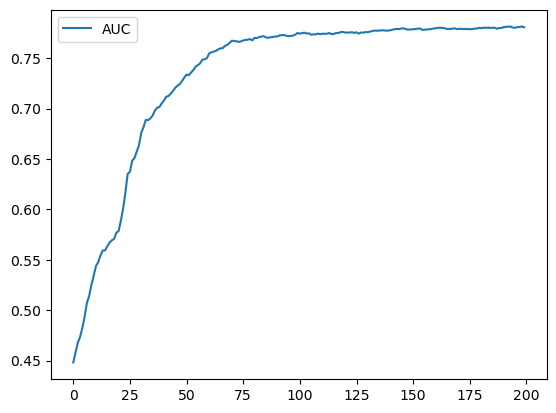

In [2482]:
# plot history
plt.plot(history.history['auc'], label='AUC')
plt.legend()
plt.show()

In [2483]:
y_test_pre=model.predict(x_test_augment)

pa=pd.DataFrame()
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa['Prediction1'] = pa['Prediction'].apply(lambda x: 1 if x >= 0.15 else 0)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [2484]:
fpr_lstm, tpr_lstm, _ = roc_curve(pa['Actual Values'], pa['Prediction'])
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

auc_scores = [roc_auc_score(pa['Actual Values'], pa['Prediction'])]
roc_curves = [(fpr_lstm, tpr_lstm)]


In [2485]:
auc_neural = metrics.roc_auc_score(pa['Actual Values'], pa['Prediction'])


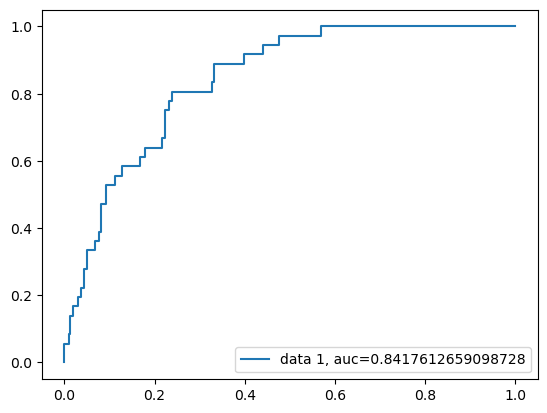

In [2486]:

fpr, tpr, _ = metrics.roc_curve(pa['Actual Values'], pa['Prediction'])

plt.plot(fpr,tpr,label="data 1, auc="+str(auc_neural))
plt.legend(loc=4)
plt.show()

While each run will result in different results. The typical result will provide an AUC of 0.84. An explanation for this result is explained in the following section

# Out-of-Sample Predictive Performance

## ROC Curves for Forecasting

To measure the out-of-sample predictive capability of our different models, we investigate the Reciever Operating Characteristic space. In this space we compare the tradeoffs between the true positive rate (the hit rate) and the false positive rate (the false alarm rate). We use AUC as a single measure of the tradeoffs, which simply measures the area under the curve in this space.

The following code splits the data into training and test sets, then the models are re-run and the out-of-sample predictive performance is recorded via AUC.

In [2487]:
X_train = X_train.drop(columns=['country', 'year'])
X_test = X_test.drop(columns=['country', 'year'])

In [2488]:
sorted_data_rate = data_rate.sort_values(by=['country', 'year'])
columns_to_keep = ['cpi_rate', 'rconsumption_rate', 'housing_rate', 'money_rate', 'DSR_rate', 'credit_rate', 'country', 'year',
                   'global_credit_rate', 'slope', 'global_slope','ca_rate',  'investment_rate',  'debtgdp_rate', 'noncore', 'lev', 'stock_rate', 'indicator']
data_smote = sorted_data_rate[columns_to_keep]

missing_rows = data_smote[data_smote.isnull().any(axis=1)]

# dropping all the rows with na's 
data_smote = data_smote.dropna()

# standardizing the data
columns_to_standardize =  ['cpi_rate', 'rconsumption_rate', 'housing_rate', 'money_rate', 'DSR_rate', 'credit_rate',
                   'global_credit_rate', 'slope', 'global_slope','ca_rate',  'investment_rate',  'debtgdp_rate', 'noncore', 'lev', 'stock_rate']
scaler = StandardScaler()
data_smote[columns_to_standardize] = scaler.fit_transform(data_smote[columns_to_standardize])
data_smote

,cpi_rate,rconsumption_rate,housing_rate,money_rate,DSR_rate,credit_rate,country,year,global_credit_rate,slope,global_slope,ca_rate,investment_rate,debtgdp_rate,noncore,lev,stock_rate,indicator
449,0.201881,-0.360813,-0.652080,-0.436655,0.147522,-0.654988,Australia,1902,-0.129854,-0.194538,-0.804990,0.061955,1.408468,-0.120645,-0.794071,1.407139,-0.139900,0
463,-0.261516,-0.029319,-0.656442,-0.598620,0.147522,0.098263,Australia,1903,-0.224598,-0.181635,-0.852109,-0.501147,0.201038,0.399111,-0.767489,1.417348,0.045137,0
477,-0.821518,0.663119,-0.750580,-0.546395,0.147522,-0.622619,Australia,1904,1.196896,-0.051417,-0.825305,2.247694,-2.502742,-0.341809,-0.728409,1.266318,-0.145051,0
492,-0.403177,-0.216924,-0.575168,-0.279722,0.147522,-0.318556,Australia,1905,0.258444,-0.174400,-1.372852,2.025113,-0.598677,0.105125,-0.698360,1.104951,0.582410,0
508,-0.256875,-1.409564,-0.103857,-0.104969,0.147522,-0.586132,Australia,1906,0.382874,-0.343230,-2.197101,0.451962,0.278050,-0.368536,-0.706451,0.988934,0.112638,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,-0.288071,-0.135756,-0.098293,-0.183195,0.147522,0.211747,USA,2016,-0.640859,0.377931,0.239300,0.021547,-0.146201,0.657504,-1.084357,0.493013,0.005969,0
1952,-0.211250,-0.123374,-0.061040,-0.246539,0.147522,-0.154200,USA,2017,-0.917938,0.307137,0.488379,0.084435,0.507329,-0.160241,-1.097936,0.509522,0.354953,0
1970,-0.185625,0.035701,-0.058903,-0.353630,0.147522,-0.333830,USA,2018,-1.077548,0.161669,0.376195,-0.144460,0.234130,0.040609,-1.117756,0.519181,-0.064077,0
1988,-0.241482,-0.139349,-0.135576,-0.281110,0.147522,-0.124981,USA,2019,-0.367818,-0.475965,-0.334627,-0.059269,0.092718,0.126687,-1.150102,0.501606,-0.036528,0


In [2489]:
country=list(set(data_smote.country))
# loop each country_Region and split the data into train and test data
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    df = data_smote[data_smote['country'] == country[i]]
    # applied the function I created above
    x_train, x_test,y_train,y_test=train_test_split(df)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)
# concatenate each train data n X_train list and Y_train list respectively
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

X_test_dropped = X_test.drop(columns=['country', 'year'])
X_train_dropped = X_train.drop(columns=['country', 'year'])
Y_train_array = Y_train.values
Y_test_array = Y_test.values


In [2490]:
# this will take a while to run

# Convert DataFrame to 1-dimensional array
Y_train_array = Y_train.values.ravel()


# Logistic Regression
logreg = LogisticRegression(penalty = 'none')
logreg.fit(X_train_dropped, Y_train_array)

# Predict probabilities for the test set
y_pred_prob_logreg = logreg.predict_proba(X_test_dropped)[:, 1]

# Compute ROC curve and AUC
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(Y_test_array, y_pred_prob_logreg)
roc_auc_logreg = roc_auc_score(Y_test_array, y_pred_prob_logreg)

# Random Forest with hyperparameter tuning using cross-validation
rf = RandomForestClassifier()

# Perform cross-validation to tune hyperparameters
hyperparameters = {'n_estimators': [50, 100, 200],
                   'max_depth': [None, 10, 20]}

rf_cv = GridSearchCV(rf, hyperparameters, cv=5, scoring='roc_auc')
rf_cv.fit(X_train_dropped, Y_train_array)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_rf = rf_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_rf = best_rf.predict_proba(X_test_dropped)[:, 1]

# Compute ROC curve and AUC for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test_array, y_pred_prob_rf)
roc_auc_rf = roc_auc_score(Y_test_array, y_pred_prob_rf)

# lasso model

# Random Forest with hyperparameter tuning using cross-validation
lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear')

# Define hyperparameters to tune
hyperparameters_lasso = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform cross-validation to tune hyperparameters
lasso_cv = GridSearchCV(lasso_logreg, hyperparameters_lasso, cv=5, scoring='roc_auc')
lasso_cv.fit(X_train_dropped, Y_train_array)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_lasso_logreg = lasso_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_lasso = best_lasso_logreg.predict_proba(X_test_dropped)[:, 1]

# Compute ROC curve and AUC
fpr_lasso, tpr_lasso, thresholds_lasso = roc_curve(Y_test_array, y_pred_prob_lasso)
roc_auc_lasso = roc_auc_score(Y_test_array, y_pred_prob_lasso)

#elastic net 

# ElasticNet model
elasticnet = ElasticNet()

# Define hyperparameters to tune
hyperparameters_elasticnet = {'alpha': [0.001, 0.01, 0.1, 1, 10],
                              'l1_ratio': [0.1, 0.5, 0.7, 0.9]}

# Perform cross-validation to tune hyperparameters
elasticnet_cv = GridSearchCV(elasticnet, hyperparameters_elasticnet, cv=5, scoring='roc_auc')
elasticnet_cv.fit(X_train_dropped, Y_train_array)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_elasticnet = elasticnet_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_elasticnet = best_elasticnet.predict(X_test_dropped)

# Compute ROC curve and AUC
fpr_elasticnet, tpr_elasticnet, _ = roc_curve(Y_test, y_pred_prob_elasticnet)
roc_auc_elasticnet = roc_auc_score(Y_test_array, y_pred_prob_elasticnet)


# gradient boosting 
gradientboost = GradientBoostingClassifier()

# Define hyperparameters to tune
hyperparameters_GB = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01,0.03, 0.05, 0.07, 0.1]
}

# Perform cross-validation to tune hyperparameters
GB_cv = GridSearchCV(gradientboost, hyperparameters_GB, cv=5, scoring='roc_auc')
GB_cv.fit(X_train_dropped, Y_train_array)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_GB = GB_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_GB = best_GB.predict_proba(X_test_dropped)[:, 1]  # Assuming binary classification

# Compute ROC curve and AUC
fpr_GB, tpr_GB, _ = roc_curve(Y_test_array, y_pred_prob_GB)
roc_auc_GB = roc_auc_score(Y_test_array, y_pred_prob_GB)


C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


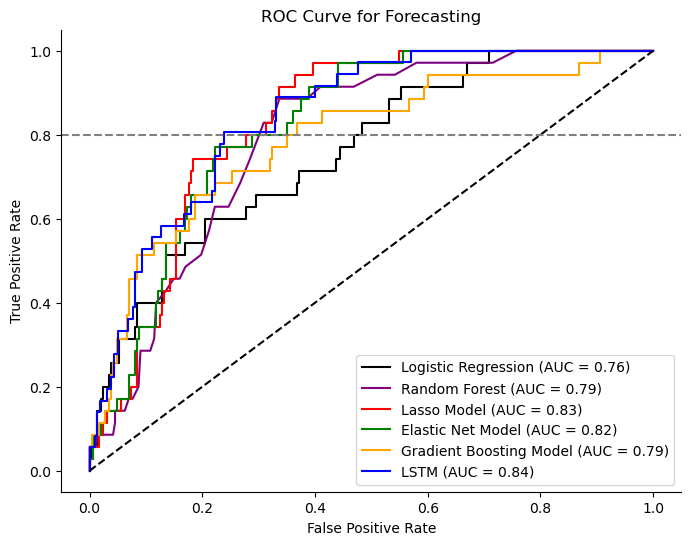

In [2491]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='black' ,label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_logreg))
plt.plot(fpr_rf, tpr_rf,  color='purple',label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot(fpr_lasso, tpr_lasso, color='red', label='Lasso Model (AUC = {:.2f})'.format(roc_auc_lasso))
plt.plot(fpr_elasticnet, tpr_elasticnet,  color='green',label='Elastic Net Model (AUC = {:.2f})'.format(roc_auc_elasticnet))
plt.plot(fpr_GB, tpr_GB,  color='orange',label='Gradient Boosting Model (AUC = {:.2f})'.format(roc_auc_GB))

plt.plot(fpr_lstm, tpr_lstm, color='blue', label='LSTM (AUC = {:.2f})'.format(auc_neural))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Forecasting')
plt.legend(loc='lower right')
plt.axhline(0.8, linestyle='--',color = 'grey') #horizontal line

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

The chart above plots the performance of the models in the ROC space. The y-axis indicates the true positive rate, or intutively the 'hit rate'. The x-axis indicates the false positive rate, or 'false alarm rate'. The measure of performance are the models tradeoffs between true and false positive rates, with the area under the curve serving as a way to compare the different models. 

The black line indicates the baseline logistic model. So we see all of our Lasso, Elastic Net, LSTM, Gradient Boosting, and Random Forest models perform better than the logsistic model. The LSTM performed the best out of all the models. To interpret this result, the LSTM can predict 80% of all crises before they occur while only incuring an 18% false alarm rate.

## SMOTE Resampling to adjust for imbalanced data

The infrequency of financial crises does cause our data to be imbalanced. Thus, to ensure that our results are robust, we resample our data using the Synthetic Minority Oversampling Technique, or SMOTE for short. This method essentially employs a k-nearest neighbor approach and synthetic data is randomly generated from the minority class (observations of crisis). 

In [2492]:
from imblearn.over_sampling import SMOTE


# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_dropped, Y_train_array)

Y_train_array_flat = y_train_resampled.flatten()

# Convert the flattened array to a Pandas Series
Y_train_series = pd.Series(Y_train_array_flat)

## Let's try this over again with a balanced dataset

In [2493]:
# Logistic Regression
logreg = LogisticRegression(penalty = 'none')
logreg.fit(X_train_resampled, Y_train_series)

# Predict probabilities for the test set
y_pred_prob_logreg = logreg.predict_proba(X_test_dropped)[:, 1]

# Compute ROC curve and AUC
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(Y_test_array, y_pred_prob_logreg)
roc_auc_logreg = roc_auc_score(Y_test_array, y_pred_prob_logreg)


C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [2494]:
# Random Forest with hyperparameter tuning using cross-validation
rf = RandomForestClassifier()

# Perform cross-validation to tune hyperparameters
hyperparameters = {'n_estimators': [50, 100, 200],
                   'max_depth': [None, 10, 20]}

rf_cv = GridSearchCV(rf, hyperparameters, cv=5, scoring='roc_auc')
rf_cv.fit(X_train_resampled, Y_train_series)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_rf = rf_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_rf = best_rf.predict_proba(X_test_dropped)[:, 1]

# Compute ROC curve and AUC for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test_array, y_pred_prob_rf)
roc_auc_rf = roc_auc_score(Y_test_array, y_pred_prob_rf)


In [2495]:
# lasso model

# Random Forest with hyperparameter tuning using cross-validation
lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear')

# Define hyperparameters to tune
hyperparameters_lasso = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform cross-validation to tune hyperparameters
lasso_cv = GridSearchCV(lasso_logreg, hyperparameters_lasso, cv=5, scoring='roc_auc')
lasso_cv.fit(X_train_resampled, Y_train_series)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_lasso_logreg = lasso_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_lasso = best_lasso_logreg.predict_proba(X_test_dropped)[:, 1]

# Compute ROC curve and AUC
fpr_lasso, tpr_lasso, thresholds_lasso = roc_curve(Y_test_array, y_pred_prob_lasso)
roc_auc_lasso = roc_auc_score(Y_test_array, y_pred_prob_lasso)


In [2496]:
#elastic net 

# ElasticNet model


elasticnet = LogisticRegression(solver="saga", penalty="elasticnet")

# Define hyperparameters to tune
hyperparameters_elasticnet = {'C': [0.001, 0.01, 0.1, 1, 10],
                              'l1_ratio': [0.1, 0.5, 0.7, 0.9]}

# Perform cross-validation to tune hyperparameters
elasticnet_cv = GridSearchCV(elasticnet, hyperparameters_elasticnet, cv=5, scoring='roc_auc')
elasticnet_cv.fit(X_train_resampled, Y_train_series)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_elasticnet = elasticnet_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_elasticnet = best_elasticnet.predict_proba(X_test_dropped)[:, 1]


# Compute ROC curve and AUC
fpr_elasticnet, tpr_elasticnet, _ = roc_curve(Y_test_array, y_pred_prob_elasticnet)
roc_auc_elasticnet = roc_auc_score(Y_test_array, y_pred_prob_elasticnet)


C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sjten\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

In [2497]:

# gradient boosting 
gradientboost = GradientBoostingClassifier()

# Define hyperparameters to tune
hyperparameters_GB = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01,0.03, 0.05, 0.07, 0.1]
}

# Perform cross-validation to tune hyperparameters
GB_cv = GridSearchCV(gradientboost, hyperparameters_GB, cv=5, scoring='roc_auc')
GB_cv.fit(X_train_resampled, Y_train_series)  # Use the 1-dimensional array

# Get the best model from cross-validation
best_GB = GB_cv.best_estimator_

# Predict probabilities for the test set
y_pred_prob_GB = best_GB.predict_proba(X_test_dropped)[:, 1]  # Assuming binary classification

# Compute ROC curve and AUC
fpr_GB, tpr_GB, _ = roc_curve(Y_test_array, y_pred_prob_GB)
roc_auc_GB = roc_auc_score(Y_test_array, y_pred_prob_GB)

In [2558]:
# neural network
sorted_data_rate = data_rate.sort_values(by=['country', 'year'])
columns_to_keep = ['country', 'year' , 'credit_rate', 'housing_rate', 'global_slope','lev_rate', 'slope', 'stock_rate', 'global_credit_rate', 'indicator']
data_neural = sorted_data_rate[columns_to_keep]

missing_rows = data_neural[data_neural.isnull().any(axis=1)]

# dropping all the rows with na's 
data_neural = data_neural.dropna()

# standardizing the data
columns_to_standardize = ['credit_rate',  'housing_rate', 'global_slope', 'slope', 'stock_rate', 'lev_rate', 'global_credit_rate']
scaler = StandardScaler()
data_neural[columns_to_standardize] = scaler.fit_transform(data_neural[columns_to_standardize])
 

##################################################
train_data=data_neural.iloc[:int(len(data_neural)*0.7)] 
test_data=data_neural.iloc[int(len(data_neural)*0.7):]
########################################################3
country=list(set(data_neural.country))
# loop each country_Region and split the data into train and test data
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    df = data_neural[data_neural['country'] == country[i]]
    # applied the function I created above
    x_train, x_test,y_train,y_test=train_test_split(df)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)
# concatenate each train data n X_train list and Y_train list respectively
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

X_train['country']= encoder.fit_transform(X_train['country'])

X_train_augment_resampled, y_train_augment_resampled = smote.fit_resample(X_train, Y_train)


####################################################3
encoder = LabelEncoder()
#combine X train and Y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train_augment_resampled
train_data[Y_train.columns]=y_train_augment_resampled
train_data['country']= encoder.fit_transform(train_data['country'])
#combine X test and Y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])



# using the function to obtian reshaped data 
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

x_train_augment = np.delete(x_train, [0, 1, 9, 10,11], axis=2)


x_test_augment =  np.delete(x_test, [0, 1, 9, 10,11], axis=2)
##########################################################
tf.random.set_seed(6)

# because of randomness of neural network, replication of results may require re-runs to see a 'good' result for in-sample AUC fit
model1 = Sequential()

# Add LSTM layer with L2 regularization
model1.add(LSTM(11, activation='sigmoid', input_shape=(x_train_augment.shape[1], x_train_augment.shape[2]),kernel_regularizer=regularizers.l2(0.1),  # Add L2 regularization with regularization strength 0.01
               recurrent_regularizer=regularizers.l2(0.1)))

model1.add(Dense(units = 1,activation='relu'))
model1.compile(loss='mse', optimizer='adam', metrics=['auc'])
history = model1.fit(x_train_augment, y_train, epochs=50, batch_size=16, verbose=1, shuffle=False)

Epoch 1/50


C:\Users\sjten\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.3417 - loss: 2.8283   
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5707 - loss: 1.2176   
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6052 - loss: 0.6263  
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6164 - loss: 0.4043  
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6231 - loss: 0.3252   
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6284 - loss: 0.2983   
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6321 - loss: 0.2891   
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6359 - loss: 0.2857   
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6388 - loss: 0.2843   
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6406 - loss: 0.2837   
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6421 - loss: 0.2835   
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6430 - loss: 0.2833   
Epoch 13/50
96/96 ━━━━━━━━

In [2559]:
# neural network continued

y_pred_prob_RNN=model1.predict(x_test_augment)


pa1=pd.DataFrame()
pa1['Prediction']=[i[0] for i in y_pred_prob_RNN][1:] 
pa1['Actual Values']=y_test[:-1]
pa1['Prediction1'] = pa1['Prediction'].apply(lambda x: 1 if x >= 0.19 else 0)

# Compute ROC curve and AUC
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob_RNN)
roc_auc_lstm = roc_auc_score(y_test, y_pred_prob_RNN)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [2560]:
y_log_binary = np.where(y_pred_prob_logreg >= 0.5, 1, 0)
y_lasso_binary = np.where(y_pred_prob_lasso >= 0.5, 1, 0)
y_rf_binary = np.where(y_pred_prob_rf >= 0.4, 1, 0)
y_gb_binary = np.where(y_pred_prob_GB >= 0.45, 1, 0)
y_rnn_binary = np.where(y_pred_prob_RNN >= 0.45, 1, 0)


In [2561]:
recall = f1_score(Y_test_array, y_log_binary)
recall2 = f1_score(Y_test_array, y_lasso_binary)
recall3 = f1_score(Y_test_array, y_rf_binary)
recall4 = f1_score(Y_test_array, y_gb_binary)
recall5 = f1_score(y_test, y_rnn_binary)

print("Logistic Model F1 Score:", recall)
print("Lasso F1 Score:", recall2)
print("Random Forest F1 Score:", recall3)
print("Gradient Boost F1 Score:", recall4)
print("LSTM RNN F1 Score:", recall5)

Logistic Model F1 Score: 0.34545454545454546
Lasso F1 Score: 0.3471074380165289
Random Forest F1 Score: 0.2711864406779661
Gradient Boost F1 Score: 0.30769230769230765
LSTM RNN F1 Score: 0.3153153153153153


Another metric to measure the out-of-sample classification ability is through the F1-Score, which serves as a tradeoff between the Recall and Precision rates. We see that the LSTM performs better on this metric than all the other models. Noticably, LASSO, Random Forest, and Gradient Boosting do not appear to perform better than the Logistic Model. 

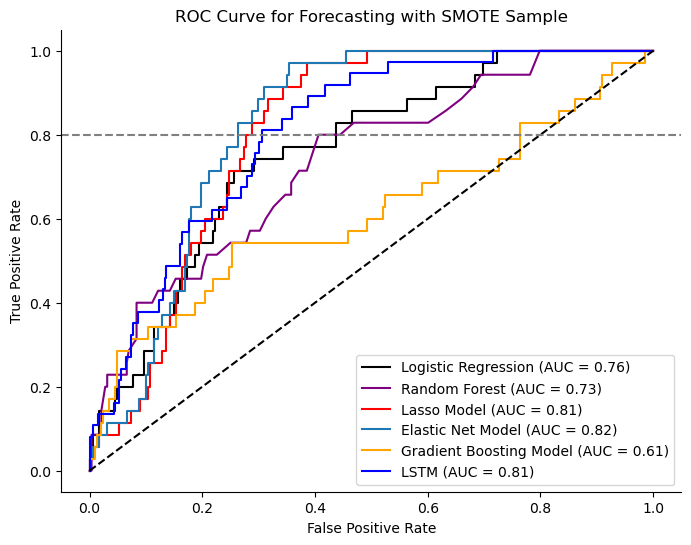

In [2562]:
# Plot ROC curves 
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg,  color='black',label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_logreg))
plt.plot(fpr_rf, tpr_rf,  color='purple',label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot(fpr_lasso, tpr_lasso,  color='red',label='Lasso Model (AUC = {:.2f})'.format(roc_auc_lasso))
plt.plot(fpr_elasticnet, tpr_elasticnet, label='Elastic Net Model (AUC = {:.2f})'.format(roc_auc_elasticnet))
plt.plot(fpr_GB, tpr_GB,  color='orange',label='Gradient Boosting Model (AUC = {:.2f})'.format(roc_auc_GB))

plt.plot(fpr_lstm, tpr_lstm, color='blue', label='LSTM (AUC = {:.2f})'.format(roc_auc_lstm))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Forecasting with SMOTE Sample')
plt.legend(loc='lower right')
plt.axhline(0.8, linestyle='--',color = 'grey') #horizontal line

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()



Resampling the data provides comparable results from the original dataset. The Elastic Net, Lasso, LSTM, and Random Forest all perform better than the baseline logistic model. However, the gradient boosting model underperforms. While the LSTM model is not the best model now, which proper hyperparameter tuning it would likely have a better fit. Overall, these results help validate the findings from the original dataset.

# Shapley Values

One of the biggest drawbacks to using black box machine learning techniques is the inability to interpret variables within the models. To combat this issue, we use Shapley Values to delve deeper into the LSTM model.

In [2183]:
x_train_2d = np.squeeze(x_train_augment, axis=1)



In [2173]:
#this will take a while to run 

import shap
background_summary = shap.sample(x_train_2d, 30)

def model_predict(data):
    # Ensure data is in the expected shape
    data = np.expand_dims(data, axis=1)  # Add singleton dimension for time steps
    return model.predict(data).flatten()

# Initialize the KernelExplainer
explainer = shap.KernelExplainer(model_predict, background_summary)

# Calculate SHAP values
shap_values = explainer.shap_values(x_train_2d, nsamples=50)  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/818 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
47/47 ━━━━━━━━━━━━━━━━━━

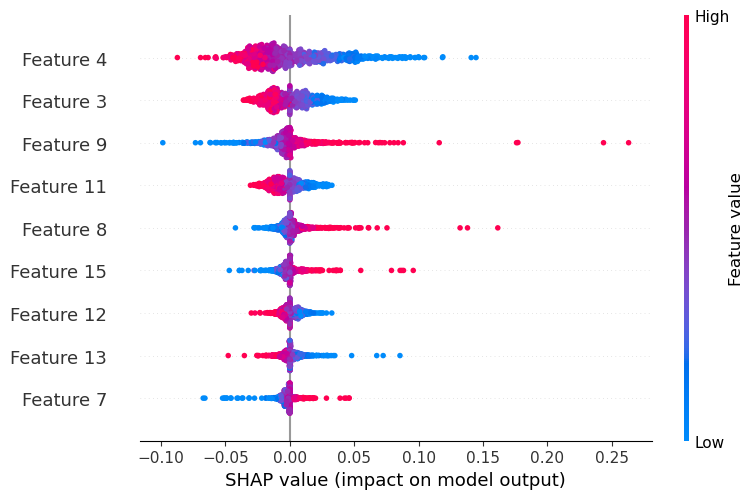

In [2176]:
shap.summary_plot(shap_values, features=x_train_2d, max_display=9)

Given the format of the data, feature values were not retained for the LSTM model and thus was not able to be included in the chart above. Feature 3 and 10 are Leverage, and the lagged version of Leverage. The Shapley Values indicate that the most important variable for the LSTM model slope of the yield curve. A low level, or inverted, yield curve is important for predicting financial crises. 

The next important feature is Global Slope (Feature 3 and lagged version, Feature 11). Low values of Global Slope, which can be interpreted as a low or inverted global yield curve, is important for the prediction of financial crises. 

Finally, the third and fourth most important features are the lagged version of the leverage ratio and the lagged version of domestic credit growth.  High rates of credit growth in the previous year predict financial crises. Additionally, high levels of the capital ratio predict financial crises. This is an interesting and counterintuitive result.

## Shapley Value Dependencies

In this section we will explore how the Shapley Values look

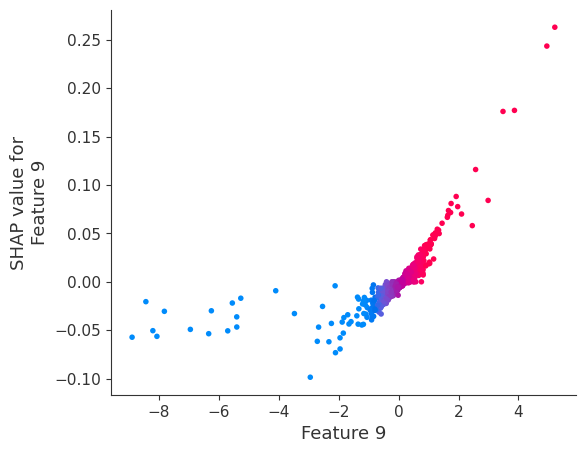

In [2251]:

# Plot SHAP dependence plot
shap.dependence_plot(9, shap_values, x_train_2d, interaction_index=9)

This plot shows the relative Leverage of the banking sector on x-axis, and the Shapley Value of the y-axis. Again, a lower Shapley Value means that observation was important for predicting a non-crisis. A high Shapley value suggests that observation was important for predicting a crisis

The relationship between the capital ratio (leverage) and its Shapley Value is nonlinear. This suggests that the capital ratio has a nonlinear relationship with predicting financial crises. 

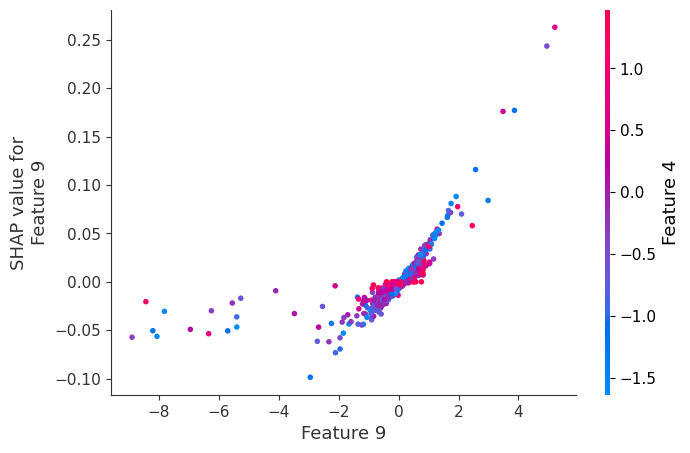

In [2252]:
shap.dependence_plot(9, shap_values, x_train_2d, interaction_index=4)

Now the color in this plot represents the value of the domestic yield curve slope. We can see that low levels of the yield curve seem to increase the elasticity of the capital ratio. A low yield curve coupled with high rates of change in the capital ratio predict financial crisis.

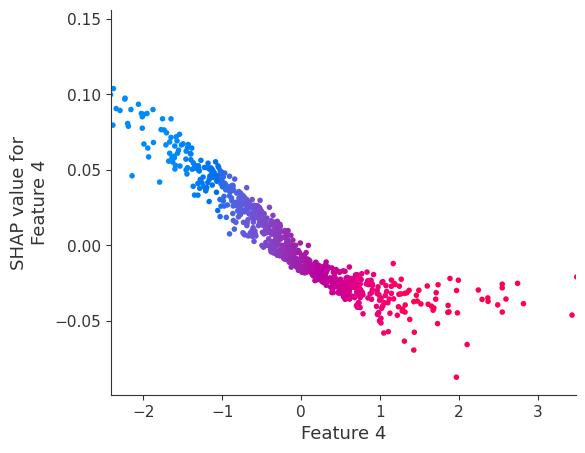

In [2255]:
# Plot SHAP dependence plot
shap.dependence_plot(4, shap_values, x_train_2d, interaction_index=4,xmin="percentile(1)", xmax="percentile(99)")

In this instance we are looking at the values and importance of the domestic slope of the yield curve. The relationship is once again not exactly linear. 

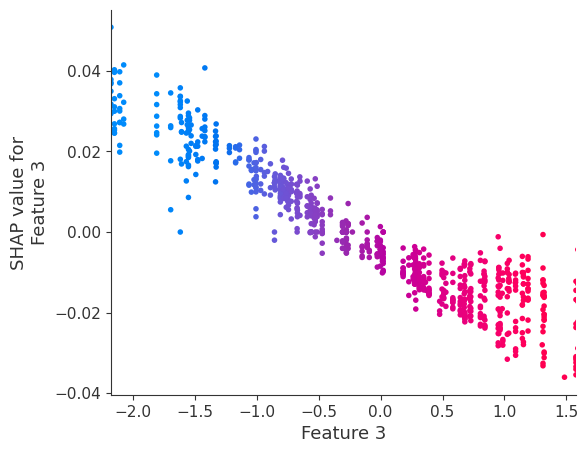

In [2242]:
shap.dependence_plot(3, shap_values, x_train_2d, interaction_index=3,xmin="percentile(1)", xmax="percentile(99)")

Here we are looking at the Shapley Values for the global slope of the yield curve. The relationship looks fairly linear.

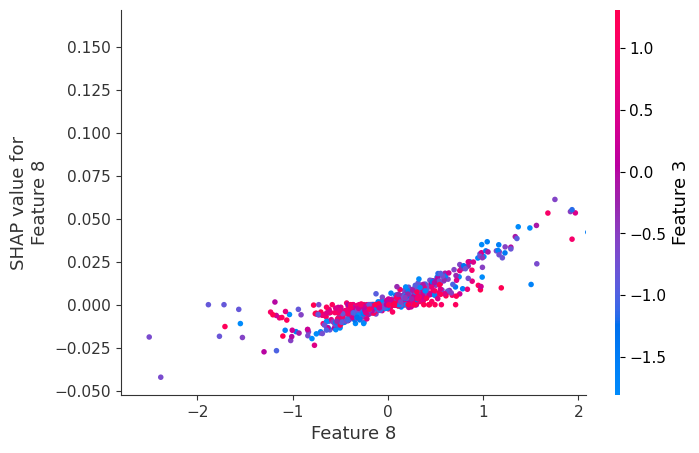

In [2248]:
shap.dependence_plot(8, shap_values, x_train_2d, interaction_index=3,xmin="percentile(1)", xmax="percentile(99)")

Here we are looking at the lag of domestic credit rate growth. The relationship appears to have some nonlinearities. The color in this plot is the value of the global slope of the yield curve. Thus, when the global slope of the yield curve is low (blue) the 'elasticity' of credit growth increases. In other words, high rates of credit growth paired with an inverted yield curve predict crisis.

In [2249]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train_2d)

This interactive plot uses Shapley Values to explain every single prediction made in our training set.

## Can our Models predict the Great Financial Crisis?

In [1105]:
test_data

,country,year,credit_rate,lev,housing_rate,global_slope,slope,stock_rate,global_credit_rate,indicator
1416,12,1981,0.167184,-0.907932,-0.452228,-0.307090,0.566865,0.021164,0.017820,0
1434,12,1982,0.179838,-0.902527,-0.355853,0.274614,1.246797,-0.029810,-0.301221,0
1452,12,1983,-0.276061,-0.641808,-0.322982,0.020819,0.168370,0.025548,-0.224140,0
1470,12,1984,-0.174663,-0.649739,-0.140974,-0.026911,-0.113068,-0.078858,-0.027076,0
1487,12,1985,-0.112408,-0.619108,-0.153820,-0.511876,-1.287632,0.032619,0.268157,0
...,...,...,...,...,...,...,...,...,...,...
1917,0,2016,0.931483,-0.478538,-0.110065,0.277888,-0.112445,-0.030763,-0.501915,0
1935,0,2017,-0.825375,-0.377701,0.046861,0.525835,0.065757,-0.011267,-0.733441,0
1953,0,2018,-0.277279,-0.378325,-0.493299,0.414160,0.236114,-0.121350,-0.866809,0
1971,0,2019,-0.730171,-0.309602,-0.638367,-0.293431,-0.279440,-1.124669,-0.273763,1


In [1271]:
# find index for usa in 2006
test_data.index[(test_data['global_credit_rate'] > 1.298845) & (test_data['global_credit_rate'] < 1.298847) & (test_data['slope'] > -0.578310) & (test_data['slope'] < -0.578308)]

Index([1819], dtype='int64')

In [1272]:
# checking our Y_test value for that year and country pair
Y_test.loc[[1819]]

,indicator
1819,1


In [1273]:
test_data_reset = test_data.reset_index()
test_data_reset.index[(test_data_reset['global_credit_rate'] > 1.298845) & (test_data_reset['global_credit_rate'] < 1.298847) & (test_data_reset['slope'] > -0.578310) & (test_data_reset['slope'] < -0.578308)]

Index([302], dtype='int64')

In [1274]:
pa.loc[300]

Prediction       0.126816
Actual Values    1.000000
Prediction1      0.000000
Name: 300, dtype: float64

In [1275]:
# percentiles 
percentiles = [85, 93, 94]

# Calculate percentiles using numpy.percentile
percentile_values = np.percentile(pa['Prediction'], percentiles)
percentile_values

array([0.14858958, 0.19733015, 0.20281132])

In [2256]:
print("The mean probability of crisis for the LSTM:", y_test_pre.mean())
print("The standard deviation of probability of crisis for the LSTM:", (y_test_pre.std()))
print("The probability of crisis within two years in 2005 (USA):", pa['Prediction'].loc[300])
print("The probability of crisis within two years in 2006 (USA):", (pa['Prediction'].loc[301]))



The mean probability of crisis for the LSTM: 0.047981113
The standard deviation of probability of crisis for the LSTM: 0.06629999
The probability of crisis within two years in 2005 (USA): 0.081257
The probability of crisis within two years in 2006 (USA): 0.049980164


The LSTM model shows elevated risk for financial crisis in the years of 2005 and 2006, with an elevated risk of 1.6 standard deviations above the average risk level. This probability of crisis occuring within the next two years in 2005 is above the 93rd percentile of risk levels produced by the model in the testing set. This model accurately predicts the 2008 financial crisis. 

In [2257]:
pa1.loc[300]

Prediction       0.479082
Actual Values    1.000000
Prediction1      1.000000
Name: 300, dtype: float64

In [2258]:
# percentiles 
percentiles = [84, 90, 95]

# Calculate percentiles using numpy.percentile
percentile_values = np.percentile(pa1['Prediction'], percentiles)
percentile_values

array([0.53774532, 0.57061158, 0.65752643])

In [2259]:
print("The mean probability of crisis for the LSTM:", y_pred_prob_RNN.mean())
print("The standard deviation of probability of crisis for the LSTM:", (y_pred_prob_RNN.std()))
print("The probability of crisis within two years in 2005 (USA):", pa1['Prediction'].loc[300])
print("The probability of crisis within two years in 2006 (USA):", (pa1['Prediction'].loc[301]))



The mean probability of crisis for the LSTM: 0.43258035
The standard deviation of probability of crisis for the LSTM: 0.11868385
The probability of crisis within two years in 2005 (USA): 0.47908184
The probability of crisis within two years in 2006 (USA): 0.43176544


Validating these results with the SMOTE sample, 2005 once again falls roughly 1.2 standard deviations above the average probability of crisis. 2005 for the USA ranks around the 85th percentile in crisis probability for the testing data. With the resampling method we still observe that the models forecasts elevated chance of crisis directly before the Great Financial Crisis. 

### Conclusion

Overall, machine learning techniques are able to predict financial crises with better efficiency than standard econometric approaches. This is an incredibly valuable tool for both policy-makers and investors alike. Policy-makers can shift monetary policy from re-active to pro-active using these early warning indicator models, and may be able to styme crisis and seriously limit contagion effects from nascent crises. For investors, knowing when to hedge against increased downside potential is incredibly valuable, and can prevent huge losses on portfolios in the event of crisis. 

We find that many of the macroeconomic variable have a nonlinear relationship when it comes to predicting financial crisis. Thus machine learning techniques like nerual networks can be useful in this field. We find that the domestic and global slope of the yield curve are the most important variable for predicting financial crisis. We also find that the global slope of the yield curve can augment the relationship that credit growth has with predicting financial crises. In line with previous research, we find that a low or inverted global yield curve coupled with high rates of domestic credit growth is an important indicator of financial crisis.